In [31]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [32]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [33]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [34]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [35]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [36]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [37]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [38]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [39]:
master_data = master_data[132:]

In [40]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [41]:
master_data.reset_index(inplace=True)

In [42]:
master_data = master_data.drop(labels='index', axis=1)

In [43]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


<h2>Load Covariate Data and Concat to Master_Data</h2>

In [44]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [45]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [46]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [47]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [48]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [49]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [50]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [51]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


<h2> Load and Concat NOI data </h2>

In [52]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [53]:
master_data.to_csv('master_data.csv')

In [54]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

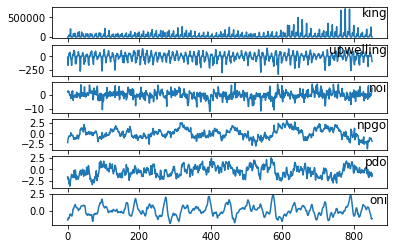

In [55]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [56]:
# convert series to supervised learning
# series_to_supervised from Jason Brownlee's "Multivariate Time Series Forecasting in Keras"
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [57]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [58]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [59]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/1000
1/1 - 3s - loss: 0.0382 - root_mean_squared_error: 0.1954 - val_loss: 0.0671 - val_root_mean_squared_error: 0.2590
Epoch 2/1000
1/1 - 0s - loss: 0.0247 - root_mean_squared_error: 0.1572 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 3/1000
1/1 - 0s - loss: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2199
Epoch 4/1000
1/1 - 0s - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2138
Epoch 5/1000
1/1 - 0s - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.0455 - val_root_mean_squared_error: 0.2134
Epoch 6/1000
1/1 - 0s - loss: 0.0149 - root_mean_squared_error: 0.1222 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2147
Epoch 7/1000
1/1 - 0s - loss: 0.0168 - root_mean_squared_error: 0.1298 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2152
Epoch 8/1000
1/1 - 0s - loss: 0.0176 - root_mean_squared_error: 0.1328 - val_loss: 0.0459 - val_root_mea

Epoch 40/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2049
Epoch 41/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0957 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 42/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2034
Epoch 43/1000
1/1 - 0s - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2023
Epoch 44/1000
1/1 - 0s - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2013
Epoch 45/1000
1/1 - 0s - loss: 0.0089 - root_mean_squared_error: 0.0941 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2003
Epoch 46/1000
1/1 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1995
Epoch 47/1000
1/1 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0395 - val_

Epoch 79/1000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1961
Epoch 80/1000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 81/1000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955
Epoch 82/1000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1953
Epoch 83/1000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952
Epoch 84/1000
1/1 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1951
Epoch 85/1000
1/1 - 0s - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1951
Epoch 86/1000
1/1 - 0s - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0381 - val_

Epoch 118/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1927
Epoch 119/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1927
Epoch 120/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1926
Epoch 121/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1926
Epoch 122/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1925
Epoch 123/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1924
Epoch 124/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1923
Epoch 125/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.037

Epoch 157/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1907
Epoch 158/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1907
Epoch 159/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1907
Epoch 160/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 161/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 162/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 163/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1905
Epoch 164/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.036

Epoch 196/1000
1/1 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895
Epoch 197/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0875 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895
Epoch 198/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895
Epoch 199/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1894
Epoch 200/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1894
Epoch 201/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1894
Epoch 202/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1894
Epoch 203/1000
1/1 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.035

Epoch 235/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1886
Epoch 236/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1886
Epoch 237/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1885
Epoch 238/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 239/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 240/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 241/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 242/1000
1/1 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.035

Epoch 274/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1878
Epoch 275/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1878
Epoch 276/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1878
Epoch 277/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1878
Epoch 278/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1878
Epoch 279/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1878
Epoch 280/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1877
Epoch 281/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.035

Epoch 313/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1871
Epoch 314/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1871
Epoch 315/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1871
Epoch 316/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1871
Epoch 317/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1871
Epoch 318/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1870
Epoch 319/1000
1/1 - 0s - loss: 0.0074 - root_mean_squared_error: 0.0857 - val_loss: 0.0350 - val_root_mean_squared_error: 0.1870
Epoch 320/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.035

Epoch 352/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1863
Epoch 353/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1863
Epoch 354/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1862
Epoch 355/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1862
Epoch 356/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1862
Epoch 357/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1862
Epoch 358/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 359/1000
1/1 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.034

Epoch 391/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1851
Epoch 392/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1851
Epoch 393/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1850
Epoch 394/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1850
Epoch 395/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1849
Epoch 396/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1849
Epoch 397/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1849
Epoch 398/1000
1/1 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.034

Epoch 430/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 431/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1832
Epoch 432/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0840 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1832
Epoch 433/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1831
Epoch 434/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1831
Epoch 435/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1830
Epoch 436/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1830
Epoch 437/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.033

Epoch 469/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1808
Epoch 470/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1807
Epoch 471/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1806
Epoch 472/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1806
Epoch 473/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0828 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1805
Epoch 474/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1804
Epoch 475/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1804
Epoch 476/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.032

Epoch 508/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1777
Epoch 509/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1776
Epoch 510/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1775
Epoch 511/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1775
Epoch 512/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1774
Epoch 513/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1773
Epoch 514/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1772
Epoch 515/1000
1/1 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.031

Epoch 547/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1735
Epoch 548/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1733
Epoch 549/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1732
Epoch 550/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1731
Epoch 551/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1729
Epoch 552/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1728
Epoch 553/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1726
Epoch 554/1000
1/1 - 0s - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.029

Epoch 586/1000
1/1 - 0s - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0277 - val_root_mean_squared_error: 0.1663
Epoch 587/1000
1/1 - 0s - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1661
Epoch 588/1000
1/1 - 0s - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1658
Epoch 589/1000
1/1 - 0s - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1656
Epoch 590/1000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1653
Epoch 591/1000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1651
Epoch 592/1000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1648
Epoch 593/1000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.027

Epoch 625/1000
1/1 - 0s - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1549
Epoch 626/1000
1/1 - 0s - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 627/1000
1/1 - 0s - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1542
Epoch 628/1000
1/1 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1538
Epoch 629/1000
1/1 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1535
Epoch 630/1000
1/1 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1532
Epoch 631/1000
1/1 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1528
Epoch 632/1000
1/1 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.023

Epoch 664/1000
1/1 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1383
Epoch 665/1000
1/1 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1377
Epoch 666/1000
1/1 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1371
Epoch 667/1000
1/1 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1366
Epoch 668/1000
1/1 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1360
Epoch 669/1000
1/1 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1354
Epoch 670/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0652 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1348
Epoch 671/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.018

Epoch 703/1000
1/1 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 704/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0587 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 705/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 706/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 707/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 708/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0581 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 709/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 710/1000
1/1 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.013

Epoch 742/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 743/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 744/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 745/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1022
Epoch 746/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019
Epoch 747/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0526 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1015
Epoch 748/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 749/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.010

Epoch 781/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 782/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 783/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 784/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 785/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 786/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 787/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 788/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0474 - val_loss: 0.007

Epoch 820/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794
Epoch 821/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792
Epoch 822/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 823/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 824/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0784
Epoch 825/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782
Epoch 826/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 827/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.006

Epoch 859/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709
Epoch 860/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 861/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709
Epoch 862/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 863/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 864/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702
Epoch 865/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0703
Epoch 866/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.005

Epoch 898/1000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0656
Epoch 899/1000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 900/1000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 901/1000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 902/1000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 903/1000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 904/1000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 905/1000
1/1 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.004

Epoch 937/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 938/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 939/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 940/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604
Epoch 941/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604
Epoch 942/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 943/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0602
Epoch 944/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.003

Epoch 976/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 977/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 978/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 979/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564
Epoch 980/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 981/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 982/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561
Epoch 983/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.003

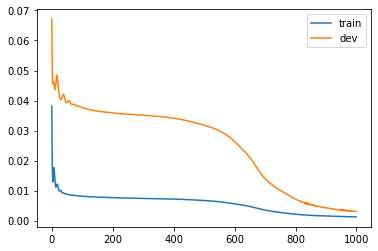

In [60]:
# design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(1))
# model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=1000, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [61]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))

In [62]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [63]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [64]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

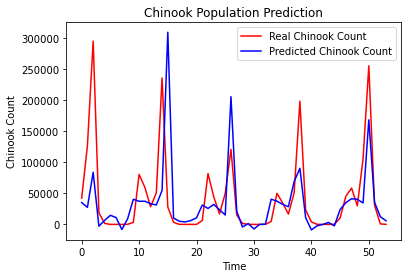

The test root mean squared error is 62513.13641147755.


In [65]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

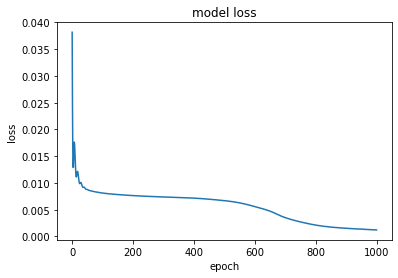

In [66]:
plot_loss(history)

In [67]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  569549
1  371801
2  290116
3  397346
    Count
0  488981
1  336030
2  381773
3  535746


In [68]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [69]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [70]:
return_rmse(actual, preds)

The test root mean squared error is 93976.50333194995.
